# BUSINESS PROBLEM - Churn Prediction

Churn rate, representa a taxa de cancelamento de algum tipo de serivço. Por exemplo: cancelamento de assinaturas do Netflix. 

Portanto, nosso principal objetivo é identificar clientes que possuem maior probabilidade de cancelar sua assinatura em determinada companhia de telecomunicação.

dataset: https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv

# 0.0. IMPORTS

In [219]:
#data manipulation
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler

#sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#data viz
import matplotlib.pyplot as plt
import seaborn as sns

In [266]:
import warnings
#warnings.filter_warnings("ignore")

## 0.1. Loading Data

In [11]:
pd.set_option('display.max_columns', None)

In [2]:
dataset = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"

#read csv
df_raw = pd.read_csv(dataset)

In [3]:
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 0.2. Helper Functions

In [217]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

# 1.0. DATA DESCRIPTION

In [5]:
#checkpoint
df1 = df_raw.copy()

## 1.1. Data Dimension

In [9]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of columns: {df1.shape[1]}")

Number of Rows: 7043
Number of columns: 21


## 1.2. Data Types

In [12]:
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df1.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

- Foi identificado que coluna TotalCharges é um float e está configurado como object.
- Iremos realizar a modificação

In [27]:
df1 = df1.loc[df1['TotalCharges'] != ' ', :]

In [28]:
#transformando coluna TotalCharges para número
df1['TotalCharges'] = df1['TotalCharges'].astype(float)

## 1.3. Missing Values

In [31]:
df1.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

- Inicialmente não encontramos valores nulos.
- É possível que haja inconsistência como espaços dentro de alguma coluna

## 1.4. Descriptive Analysis

In [34]:
#split data
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64'])

### 1.4.1. Numerical Attributes

In [45]:
pd.DataFrame(num_attributes.describe(percentiles = list(np.arange(0.1,1.1,0.1)))).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.00,0.00,0.000,0.00,0.000,0.00,0.000,0.00,1.000,1.00,1.00
tenure,7032.0,32.421786,24.545260,1.00,2.00,6.00,12.000,20.00,29.000,40.00,50.000,60.80,69.000,72.00,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,20.05,25.05,45.900,58.92,70.350,79.15,85.535,94.30,102.645,118.75,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,84.60,267.07,551.995,944.17,1397.475,2048.95,3141.130,4475.41,5976.640,8684.80,8684.80


- A variável SeniorCitizen não possui grande variabilidade, ou seja, a maioria dos clientes não o possuiam. Portanto, pode ser uma informação irrelevante na construção do nosso modelo preditivo.
- tenure nos sugere que não há inconsistência;
- MonthlyCharges está correta;
- TotalCharges está correta

Algoritmos de Machine Learning partem da premissa que as distribuições são normais. Ou seja, funciona bem quando as variáveis que enviamos possue uma distribuição semelhante.

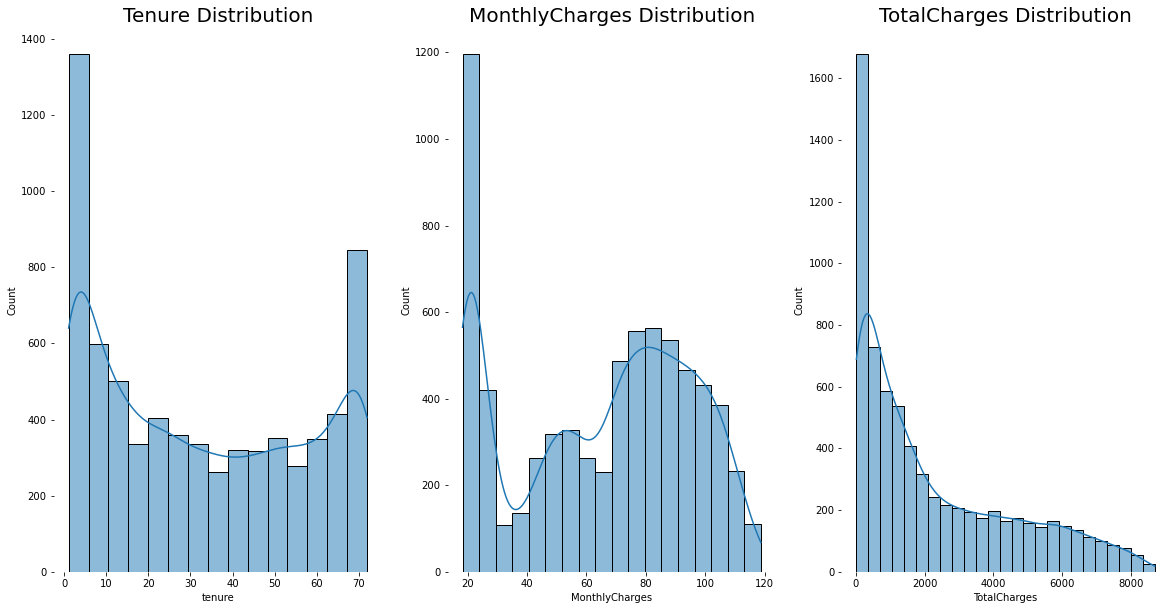

In [55]:
plt.figure(figsize = (20,10))

plt.subplot(1,3,1)

sns.histplot(x = 'tenure', data = num_attributes, kde = True)
plt.title("Tenure Distribution", fontsize = 20);
plt.box(False)

plt.subplot(1,3,2)
sns.histplot(x = 'MonthlyCharges', data = num_attributes, kde = True)
plt.title("MonthlyCharges Distribution", fontsize = 20);
plt.box(False)

plt.subplot(1,3,3)
sns.histplot(x = 'TotalCharges', data = num_attributes, kde = True)
plt.title("TotalCharges Distribution", fontsize = 20);
plt.box(False)

### 1.4.2. Categorical Attributes

In [221]:
cat_attributes['Churn'].value_counts(normalize = True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

In [66]:
cat_attributes.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [76]:
colunas = ['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

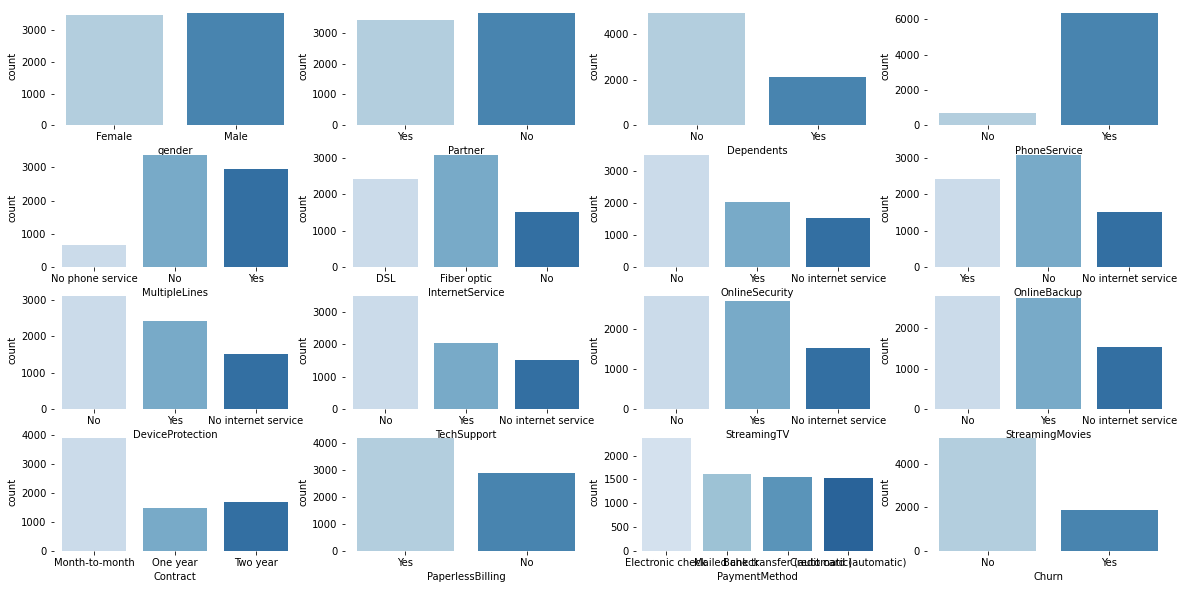

In [93]:
plt.figure(figsize = (20,10))


for i in range(len(colunas)):
    plt.subplot(4,4,i + 1)
    
    sns.countplot(x = colunas[i], data = cat_attributes, palette = 'Blues')
    plt.box(False);

# 2.0. FEATURE ENGINEERING

In [94]:
df2 = df1.copy()

# 3.0. EXPLORATORY DATA ANALYSIS

In [95]:
df3 = df2.copy()

Qual o objetivo da análise exploratória:

1. Entender o negócio;
2. Validar hipóteses;
3. Confrontar uma ideia de negócio que não era baseada em dados;

## H1. Pessoas que são assinantes mensais tem maior taxa de Churn

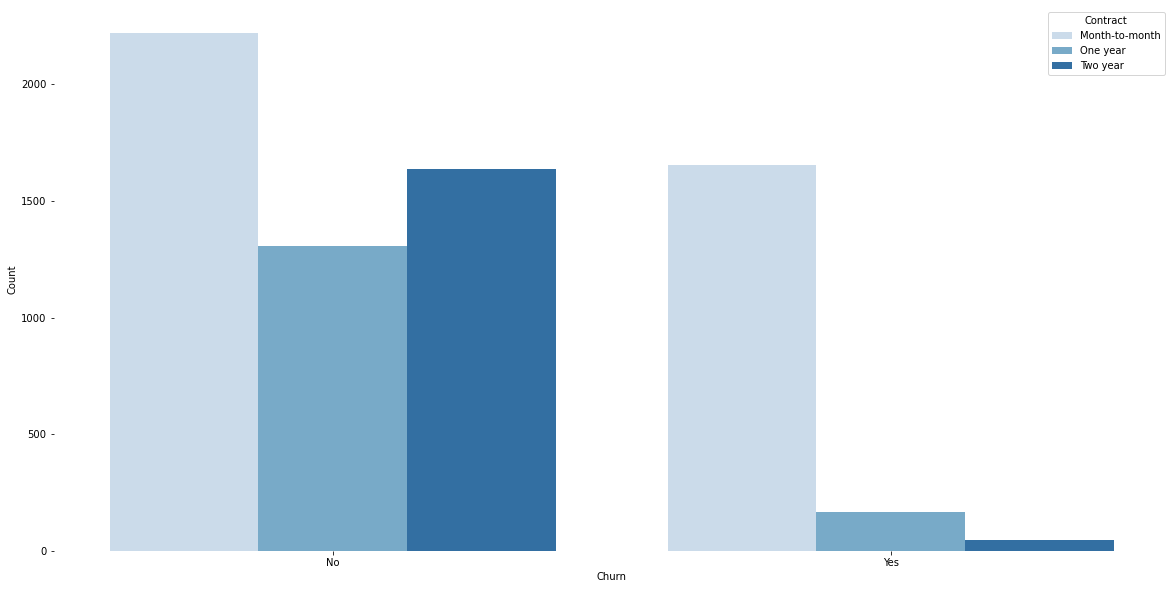

In [114]:
aux = df2[['Churn','Contract']].groupby(["Churn",'Contract']).size().reset_index().rename(columns = {0:'Count'})

plt.figure(figsize = (20,10))
sns.barplot(x = 'Churn', y = 'Count',hue = 'Contract', data = aux, palette = 'Blues');
plt.box(False)

- A hipótese de que os clientes que entraram em churn eram em sua grande maioria assinantes mensais foi validada.

## H2. Pessoas que tiveram um gasto total maior tendem e permanecer na empresa

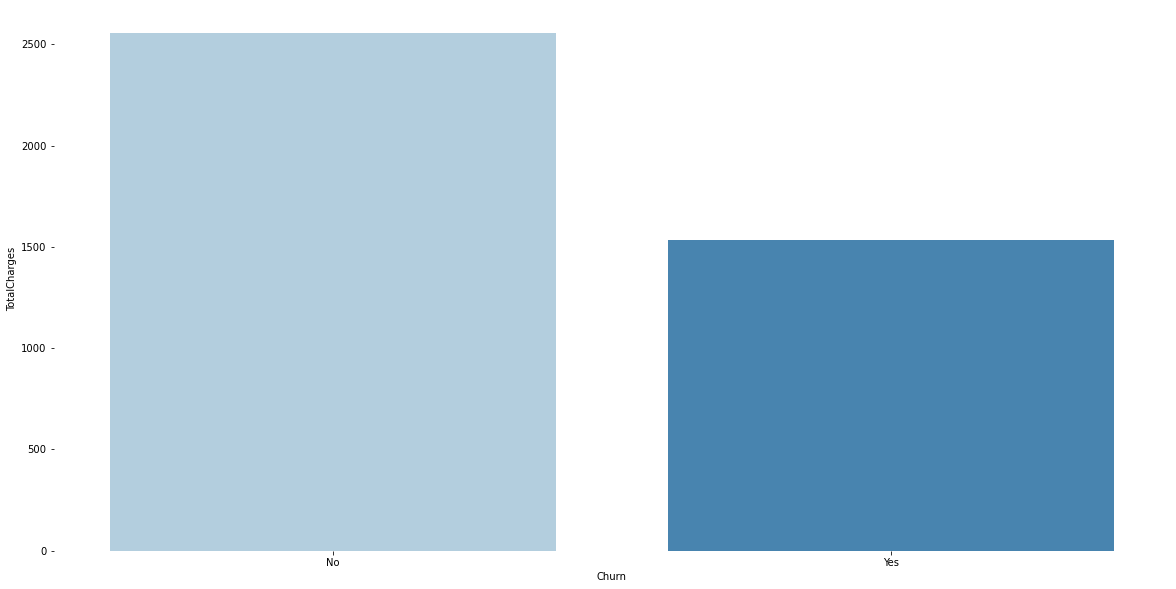

In [125]:
aux = df3[['Churn','TotalCharges']].groupby("Churn").mean().reset_index()

plt.figure(figsize = (20,10))
sns.barplot(x = 'Churn', y = 'TotalCharges', data = aux, palette = 'Blues')
plt.box(False);

# 4.0. DATA PREPARATION

## 4.1. Encoding

O processo de transformar texto em número é chamado de encoding. Existem várias formas de realizá-lo e é necessário entender qual a melhor maneira para minimizar o viés.

Ou seja, TODO tipo de transformação de dados pode carregar consigo algum tipo de viés.

Os dois principais encoders são:

- OneHotEncoder: Criar colunas binárias para classe
    - Aumenta a dimensionalidade da base
- LabelEncoder: Substituir o texto por um número
    - Problema: Há uma ordenança

In [222]:
df4 = df3.copy()

In [223]:
df4 = df4.drop(columns = ['customerID'], axis = 1)

In [224]:
binary_var = df4.nunique()[df4.nunique() == 2].keys().to_list()

num_var = [col for col in df4.select_dtypes(include = ['int64','float64']).columns.tolist() if col not in binary_var]

cat_var = [col for col in df4.columns.tolist() if col not in binary_var + num_var]

In [225]:
le = LabelEncoder()

for var in binary_var:
    df4[var] = le.fit_transform(df4[var])
    


In [226]:
df_ = pd.get_dummies(df4, columns = cat_var)

## 4.2. Normalization

In [204]:
ss = StandardScaler()

df_['tenure'] = ss.fit_transform(df_[['tenure']])
df_['MonthlyCharges'] = ss.fit_transform(df_[['MonthlyCharges']])
df_['TotalCharges'] = ss.inverse_transform(df_[['TotalCharges']])

## 4.3. Split data into training and test

In [227]:
X = df_.drop(columns = ['Churn'], axis = 1)
y = df_['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [228]:
X.shape[0], X_train.shape[0], X_test.shape[0]

(7032, 5625, 1407)

# 5.0. FEATURE SELECTION

# 6.0. MACHINE LEARNING MODELLING

- Logistic Regression
- RandomForest

## 6.1. Logistic Regression

In [207]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
905,1,1,0,0,-0.954296,1,1,1.186743,27699.808662,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
5793,1,0,0,0,-0.750577,1,1,-0.309077,23155.645447,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
3433,1,0,0,0,1.164390,1,1,1.427737,196268.559015,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
3746,0,0,1,0,-1.280248,1,1,0.138007,2139.078603,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
6416,1,0,0,0,1.408853,0,0,-0.694666,93240.450698,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0


In [208]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [209]:
yhat = lr.predict(X_test)

In [212]:
X_test['Churn'] = y_test

In [214]:
X_test['Prediction'] = yhat

In [229]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.48 (+/- 0.02)


# 7.0. RANDOM UNDER SAMPLING

In [232]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [235]:
y_train.value_counts()

0    4128
1    1497
Name: Churn, dtype: int64

In [238]:
rus = RandomUnderSampler()

In [239]:
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [241]:
y_train_rus.value_counts()

0    1497
1    1497
Name: Churn, dtype: int64

In [244]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
rf.fit(X_train_rus, y_train_rus)

RandomForestClassifier()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1986,0,0,1,1,69,1,1,93.3,6398.05,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0


In [261]:
print("Probabilidade de ser aprovado: {}%".format(rf.predict_proba(X_test.head(1))[:,1][0]*100))

Probabilidade de ser aprovado: 16.0%


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# 8.0. MODEL PERFORMANCE

# 9.0. HYPERPARAMTER FINE TUNNING

# 10.0. DEPLOY MODEL